<picture>
    <source srcset="https://media.githubusercontent.com/media/probabl-ai/skore/main/sphinx/_static/images/Logo_Skore_Dark@2x.svg" media="(prefers-color-scheme: dark)">
    <img width="200" src="https://media.githubusercontent.com/media/probabl-ai/skore/main/sphinx/_static/images/Logo_Skore_Light@2x.svg" alt="skore logo">
</picture>

# Skore and skrub demo

First of all, check the version of skore and relevant libraries:

In [1]:
!pip freeze | grep -E "skore|skrub|scikit-learn"

scikit-learn==1.6.1
skore==0.8.2
skrub==0.5.3


# End-to-end machine learning with one-liners

## Data loading and exploration

Let us load the California housing dataset about predicting house prices (regression task) and perform some exploratory data analysis (EDA) on it:

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from skrub import TableReport

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_y = pd.concat([X, y], axis=1)

TableReport(X_y)

Processing column   9 / 9


,,,,,,,,,


- We just imported skrub which is another open source and free package by the scikit-learn team. They have implemented it outside of scikit-learn for maintenance reasons and speed of releases. It started in 2018 (before Probabl was launched) and has a lot of momentum. Check out our list of open-source libraries at https://probabl.ai/labs.
- A great feature from skrub is its `TableReport`:
    - `pip install skrub` should always work because it has very low number of dependencies and the interactiveness of the `TableReport` is implemented from scratch.
    - *Stats* tab: we observe that we have only numerical features and no missing values.
    - *Distributions* tab: we notice some outliers.
    - *Associations* tab: Cramér's V can be interpreted same as correlations, but it also works with categorical features.

We split our data:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Modelling

We define our first estimator:

In [4]:
from skrub import tabular_learner

model_1 = tabular_learner("regressor")
model_1

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

- The `tabular_learner` is another great feature from skrub: it automatically generates a big scikit-learn pipeline with some preprocessing then a `HistGradientBoostingRegressor` estimator:
    - This is not auto-ML, this is hard-coded human intelligence: for example, if we detect a datetime feature, then we extract the year, month, etc from it. 
    - You can of course customize this pipeline further.
    - This provides a baseline, a strong baseline!

## Model evaluation and inspection

Now, let us evaluate and inspect our model using a feature from skore:

In [5]:
from skore import EstimatorReport

model_report_1 = EstimatorReport(
    model_1,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

skore has an `EstimatorReport`: you feed it your scikit-learn pipeline and the data, and you get some a lot of insights on your model:

In [6]:
model_report_1.help()

╭───────────── Tools to diagnose estimator HistGradientBoostingRegressor ──────────────╮
│ EstimatorReport                                                                      │
│ ├── .metrics                                                                         │
│ │   ├── .prediction_error(...)         - Plot the prediction error of a regression   │
│ │   │   model.                                                                       │
│ │   ├── .r2(...)               (↗︎)     - Compute the R² score.                       │
│ │   ├── .rmse(...)             (↘︎)     - Compute the root mean squared error.        │
│ │   ├── .timings(...)                  - Get all measured processing times related   │
│ │   │   to the estimator.                                                            │
│ │   ├── .custom_metric(...)            - Compute a custom metric.                    │
│ │   └── .report_metrics(...)           - Report a set of metrics for our estimator.  │
│ ├── .feature_importance                                                              │
│ │   └── .permutation(...)              - Report the permutation feature importance.  │
│ ├── .cache_predictions(...)            - Cache estimator's predictions.              │
│ ├── .clear_cache(...)                  - Clear the cache.                            │
│ ├── .get_predictions(...)              - Get estimator's predictions.                │
│ └── Attributes                                                                       │
│     ├── .X_test                        - Testing data                                │
│     ├── .X_train                       - Training data                               │
│     ├── .y_test                        - Testing target                              │
│     ├── .y_train                       - Training target                             │
│     ├── .estimator_                    - The cloned or copied estimator              │
│     ├── .estimator_name_               - The name of the estimator                   │
│     └── .fit_time_                     - The time taken to fit the estimator, in     │
│         seconds                                                                      │
│                                                                                      │
│                                                                                      │
│ Legend:                                                                              │
│ (↗︎) higher is better (↘︎) lower is better                                             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

You can evaluate your model using the `metrics` accessor:

In [7]:
report_metrics_1 = model_report_1.metrics.report_metrics()
report_metrics_1

,HistGradientBoostingRegressor
Metric,
R²,0.834289
RMSE,0.468023
Fit time,0.460594
Predict time,0.014346


You can also add your custom scores to the above report on metrics (if you have used scikit-learn's `make_scorer`).

You can also perform some inspection using the `feature_importance` accessor, for example the permutation feature importance:

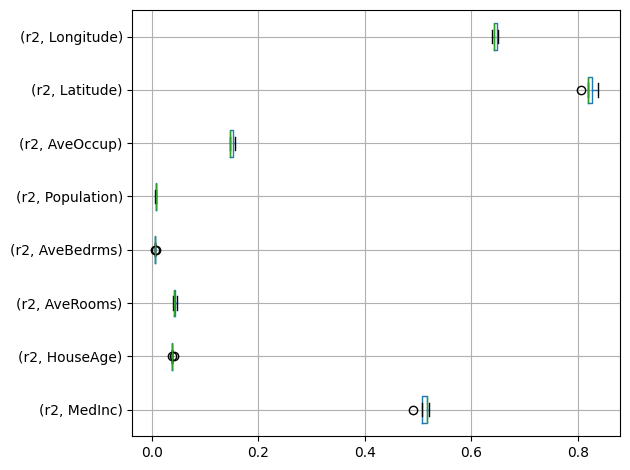

In [8]:
import matplotlib.pyplot as plt

model_report_1.feature_importance.permutation(data_source="test").T.boxplot(vert=False)
plt.tight_layout()

- The `EstimatorReport` works for all scikit-learn compatible estimators or pipelines (have `.fit()` and `.transform()` or `.predict()`), including deep learning with
    - `skorch`: this is pytorch but with `.fit()` and `.predict()`
    - `keras`: directly compatible

And... that's it!
- in one line, you have the EDA with `skrub.TableReport`
- in one line, you create a pipeline with `skrub.tabular_learner`
- in one line, you evaluated and inspected your model with `skore.EstimatorReport`

We have helped you achieve an end-to-end machine learning workflow with 3 one-liners! This is the vision of data science we have at Probabl, helping you get started and avoid white sheet anxiety. Then, based on these insights, you can iterate and refine.

# Creating a skore project

Apart from the ML methological aspects, skore can also help you perform some experiment tracking.
The skore `Project` helps you store all kinds of objects.

Let us create a skore project:

In [9]:
from skore import Project

my_project = Project("my_project", if_exists="load")
my_project.clear(delete_project=False)  # clear the project if it already exists

- You can see the `my_project.skore` folder in your directory: it was just created.
    - It exists even when you close this notebook.
- To save objects, there is no need to remember `pd.to_csv`, `plt.savefig`, etc: we have one unified API for all python objects.

`put` does the storing, and I can annotate my stored objet with any information, such as in a journal of experiments:

In [10]:
my_project.put(
    "report_metrics", report_metrics_1, note="skrub tabular learner"
)  # this is a pandas dataframe
my_project.put(
    "model_report", model_report_1, note="skrub tabular learner"
)  # this is a skore estimator report

`get` loads / fetches my previously stored object:

In [11]:
my_project.get("report_metrics")

,HistGradientBoostingRegressor
Metric,
R²,0.834289
RMSE,0.468023
Fit time,0.460594
Predict time,0.014346


We can also get the annotation and storage date:

In [12]:
my_project.get("report_metrics", metadata="all")

{'value':               HistGradientBoostingRegressor
 Metric                                     
 R²                                 0.834289
 RMSE                               0.468023
 Fit time                           0.460594
 Predict time                       0.014346,
 'date': '2025-04-24T18:11:57.986353+00:00',
 'note': 'skrub tabular learner'}

# Trying out another model

Now, after the `tabular_learner` model, let us create a second one, a simple Ridge regressor with some scaling:

In [13]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model_2 = make_pipeline(StandardScaler(), Ridge())

model_report_2 = EstimatorReport(
    model_2,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
report_metrics_2 = model_report_2.metrics.report_metrics()
report_metrics_2

,Ridge
Metric,
R²,0.591163
RMSE,0.735134
Fit time,0.003659
Predict time,0.000528


I use the exact same `report_metrics` key to store this second model, and we will see that nothing is overwritten:

In [14]:
my_project.put("report_metrics", report_metrics_2, note="scaler then ridge")
my_project.put("model_report", model_report_2, note="scaler then ridge")

I can retrieve everything I previously stored, nothing is lost (unless you explicitely delete something):

In [15]:
my_project.get("report_metrics", version="all", metadata="all")

[{'value':               HistGradientBoostingRegressor
  Metric                                     
  R²                                 0.834289
  RMSE                               0.468023
  Fit time                           0.460594
  Predict time                       0.014346,
  'date': '2025-04-24T18:11:57.986353+00:00',
  'note': 'skrub tabular learner'},
 {'value':                  Ridge
  Metric                
  R²            0.591163
  RMSE          0.735134
  Fit time      0.003659
  Predict time  0.000528,
  'date': '2025-04-24T18:11:58.043547+00:00',
  'note': 'scaler then ridge'}]

For example, let us load the last estimator report and retrieve the testing data from it:

In [16]:
report_load = my_project.get("model_report")
report_load.estimator_.predict(report_load.X_test)

array([2.27810765, 2.79618181, 1.90915868, ..., 2.1564594 , 3.0349544 ,
       2.8905238 ], shape=(5160,))

We can access a specific version of my item:

In [17]:
model_report_1_get = my_project.get("model_report", version=0)
model_report_1_get.metrics.report_metrics()

,HistGradientBoostingRegressor
Metric,
R²,0.834289
RMSE,0.468023
Fit time,0.460594
Predict time,0.014346


Furthermore, we can easily benchmark estimators using the `ComparisonReport`:

In [18]:
from skore import ComparisonReport

comparator = ComparisonReport(reports=[model_report_1, model_report_2])
comparator.metrics.report_metrics()

Output()

Estimator,HistGradientBoostingRegressor,Ridge
Metric,,
R²,0.834289,0.591163
RMSE,0.468023,0.735134
Fit time,0.460594,0.003659
Predict time,0.014346,0.000528


Or, we can also directly compare all our stored iterations:

In [19]:
comparator = ComparisonReport(reports=my_project.get("model_report", version="all"))
comparator.metrics.report_metrics()

Output()

Estimator,HistGradientBoostingRegressor,Ridge
Metric,,
R²,0.834289,0.591163
RMSE,0.468023,0.735134
Fit time,0.460594,0.003659
Predict time,0.014346,0.000528
